# Q2
## 2.1

We have the 1D HMM:

\begin{align*}
\pi_0(x_0) &= \mathcal{N}(x_0; m_0, P_0) \\
\tau(x_t | x_{t-1}) &= \mathcal{N}(x_t; \theta x_{t-1}, Q) \\
g(y_t | x_t) &= \mathcal{N}(y_t; H x_t, R)
\end{align*}

We know the exact marginal likelihood $Z_* = p(y_{1:T})$ is given by

$$
p(y_{1:T}) = \int p(x_{0:T}, y_{1:T}) dx_{0:T}
$$

$$
= \int \pi_0(x_0) \prod_{t=1}^T \bigg(\tau(x_t | x_{t-1}) g(y_t | x_t) \bigg) dx_{0:T}
$$

We also note that equivalently

$$
p(y_{1:T}) = \prod_{t=1}^T p(y_t \mid y_{1:t-1})
$$

Where

$$
p(y_t \mid y_{1:t-1}) = \int p(y_t \mid x_t) p(x_t \mid y_{1:t-1}) \, dx_t
$$

Since we have a fully Gaussian HMM setup, we can use Kalman filter to compute 
$p(x_t \mid y_{1:t-1}) =  \mathcal{N}(x_t; \hat{m}_t, \hat{P}_t)$, where

\begin{align*}
\hat{m}_t &= \theta m_{t-1} \\
\hat{P}_t &= \theta P_{t-1} \theta^\top + Q
\end{align*}

So that we have 

$$
p(y_t \mid y_{1:t-1}) = \int \mathcal{N}(y_t; H x_t, R) \cdot \mathcal{N}(x_t; \hat{m}_t, \hat{P}_t) \, dx_t
$$

By Lemma 3.2, this is

$$
p(y_t \mid y_{1:t-1}) = \mathcal{N}(H \hat{m}_t , H^2 \hat{P}_t + R) = \mathcal{N}(H \hat{m}_t , S_t)
$$

Where we let $S_t = H^2 \hat{P}_t + R$ for simplicity


The full algorithm for computing $\log p(y_{1:T}) = \sum_{t=1}^T \log p(y_t \mid y_{1:t-1})$ is given by

- Input:
Starting point $ m_0, P_0$, and the sequence of observations $ y_{1:T} $ for the specific T.

    Set $\hat{m}_0 = m_0, \hat{P}_0 = P_0$

- Filtering:  
**For** $ n = 1, \dots, T $ **do**
    - Prediction step:
    \begin{align*}
    \hat{m}_t &= \theta m_{t-1} \\
    \hat{P}_t &= \theta P_{t-1} \theta^\top + Q
    \end{align*}

    - Update step:
    \begin{align*}
    S_t &= H \hat{P}_t H^\top + R \\
    K_t &= \hat{P}_t H^\top (S_t)^{-1} \\
    m_t &= \hat{m}_t + K_t (y_t - H \hat{m}_t) \\
    P_t &= (I - K_t H) \hat{P}_t
    \end{align*}

    **End for**    

- Return $ \hat{m}_{1:T}, S_{1:T}$

And we output
$$
\log p(y_{1:T}) = \sum_{t=1}^T \log \mathcal{N}(y_t; H \hat{m}_{t}, S_t)
$$



## 2.2

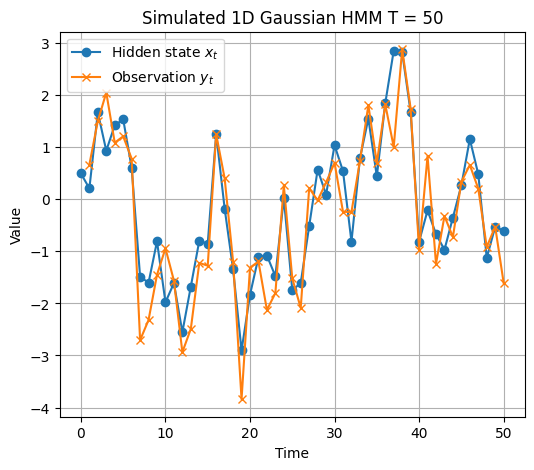

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
np.random.seed(42)
theta = 0.7
Q = 1.0
R = 0.5
P0 = 1.0
m0 = 0.0
H = 1.0
T = 50

# Initialize arrays
def simulate_hmm_q2(theta, Q, R, P0, m0, H, T):
    x = np.zeros(T + 1)  # state: x_0 to x_T
    y = np.zeros(T)      # observations: y_1 to y_T

    # Initial state
    x[0] = np.random.normal(m0, np.sqrt(P0))

    # Simulate the HMM
    for t in range(1, T + 1):
        x[t] = np.random.normal(theta * x[t - 1], np.sqrt(Q))         # state evolution
        y[t - 1] = np.random.normal(H * x[t], np.sqrt(R))             # observation

    return x, y

### sanity check
x,y = simulate_hmm_q2(theta, Q, R, P0, m0, H, T)

# Plot results
plt.figure(figsize=(6, 5))
plt.plot(range(T + 1), x, label='Hidden state $x_t$', marker='o')
plt.plot(range(1, T + 1), y, label='Observation $y_t$', marker='x')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Simulated 1D Gaussian HMM T = 50')
plt.grid(True)
plt.show()


In [2]:
T_range = [10, 20, 50, 100, 200, 500, 1000]
q2_data = {}
for t in T_range:
    x, y = simulate_hmm_q2(theta, Q, R, P0, m0, H, t)
    q2_data[t] = (x, y)

In [3]:
def kalman_filter_loglik(y, theta, Q, R, H, m0, P0):
    """
    Computes log p(y_{1:T}) = sum_t log N(y_t; H m_hat_t, S_t)
    """
    T = len(y)
    
    # Initialize
    m_hat = m0
    P_hat = P0
    
    m_filtered = np.zeros(T)
    S = np.zeros(T)
    loglik = 0.0
    
    for t in range(T):
        # Prediction step
        m_hat = theta * m_hat
        P_hat = theta * P_hat * theta + Q
        
        # Update step
        S_t = H * P_hat * H + R
        K_t = P_hat * H / S_t
        m_t = m_hat + K_t * (y[t] - H * m_hat)
        P_t = (1 - K_t * H) * P_hat
        
        # Store results
        m_filtered[t] = m_hat
        S[t] = S_t
        
        # Increment log-likelihood
        loglik += -0.5 * (np.log(2 * np.pi * S_t) + ((y[t] - H * m_hat) ** 2) / S_t)
        
        # Prepare for next iteration
        m_hat = m_t
        P_hat = P_t

    return m_filtered, S, loglik


In [4]:
loglik_dict = {}
for t, (x, y) in q2_data.items():
    m_filtered, S, log_py = kalman_filter_loglik(y, theta, Q, R, H, m0, P0)
    loglik_dict[t] = log_py
    print(f"T = {t}, log p(y_{1}:{t}) = {log_py:.2f}")

T = 10, log p(y_1:10) = -16.83
T = 20, log p(y_1:20) = -28.84
T = 50, log p(y_1:50) = -88.47
T = 100, log p(y_1:100) = -164.51
T = 200, log p(y_1:200) = -331.26
T = 500, log p(y_1:500) = -837.67
T = 1000, log p(y_1:1000) = -1702.22


## 2.3

Again we have
$$
p(y_{1:n}) = p(y_{1:n-1}) p(y_n|y_{1:n-1})
$$

Where the conditional likelihood

$$
p(y_n|y_{1:n-1}) = \int g(y_n|x_n) p(x_n|y_{1:n-1}) \, \mathrm{d}x_n
$$

can be estimated by BPF:

$$
p^N(y_n|y_{1:n-1}) = \frac{1}{N} \sum_{i=1}^{N} g(y_n|\tilde{x}_n^{(i)})
$$

Where $\tilde{x}_n^{(i)}$ are the final resampled outputs of the BPF. So that the full marginal likelihood is given by

$$
p^N(y_{1:n}) = \prod_{k=1}^{t} p^N(y_k|y_{1:k-1})
$$

As we are working with the log domain, we have

\begin{align*}
\log p^N(y_n | y_{1:n-1}) =& \log \sum_{i=1}^{N} \exp\left( \log g(y_n | \tilde{x}_n^{(i)}) \right) - \log N, \\

=& \log \sum_{i=1}^{N} \exp\left( \log W_n^{(i)} \right) - \log N
\end{align*}

#### Pseudocode

Recall setup:

\begin{align*}
\pi_0(x_0) &= \mathcal{N}(x_0; m_0, P_0) \\
\tau(x_t | x_{t-1}) &= \mathcal{N}(x_t; \theta x_{t-1}, Q) \\
g(y_t | x_t) &= \mathcal{N}(y_t; H x_t, R)
\end{align*}

The whole BPF pseudocode is given by

**Sample:**  
$ x_0^{(i)} \sim \pi_0 $ for $ i = 1, \ldots, N. $  

**for** $ t = 1, \ldots, T $ **do**

- Sample:
$ \bar{x}_t^{(i)} \sim \tau_{\theta}(\cdot|x_{t-1}^{(i)}) \quad \text{for} \quad i = 1, \ldots, N. $

- Weight:
$
W_t^{(i)} = g_{\theta}(y_t|\bar{x}_t^{(i)}),
$
for $ i = 1, \ldots, N $.

- Store:
$
p^N(y_t|y_{1:t-1}) = \frac{1}{N} \sum_{i=1}^{N} W_t^{(i)}
$

- Normalize
$
w_t^{(i)} = \frac{W_t^{(i)}}{\sum_{j=1}^{N} W_t^{(j)}},
$

- Resample: 
Sample $ o_t(1), \dots, o_t(N) \sim $ Multinomial( $w_t^{(1)}, \dots, w_t^{(N)}$ ),
and set $ x_t^{(i)} = \bar{x}_t^{(o_t(i))} $ for $ i = 1, \ldots, N $.

Return $p^N(y_{1:n}) = \prod_{k=1}^{t} p^N(y_k|y_{1:k-1})$






## 2.4 BPF Implementation

We reference our `log_p` function from Q1, and modify the `bpf` algo to store the average weight at each step, as our estimate of marginal likelihood at each step.

We also remove all the vectorizations, as all params are 1d in this question

In [5]:
def log_p(y, y_pred, R):
    '''y: scalar, y_pred: (N,), R: scalar variance'''
    diff = y_pred - y  # (N,)
    mahalanobis = (diff ** 2) / R  # (N,)
    log_det_R = np.log(R)
    
    log_likelihoods = -0.5 * (mahalanobis + np.log(2 * np.pi) + log_det_R)
    return log_likelihoods

def bpf_q2(Y, A, Q, H, R, m0, P0, N=500):
    T = len(Y)
    W = np.zeros((T, N))
    log_marginal_likelihood = 0.0
    
    # Step 1: init particles
    x = np.random.normal(loc=m0, scale=np.sqrt(P0), size=N)  # (N,)
    particle_history = []

    for t in range(T):
        # Step 2: Propagation
        noise = np.random.normal(loc=0.0, scale=np.sqrt(Q), size=N)
        x = A * x + noise  # (N,)
        
        # Step 3: Weight Update
        y = Y[t]
        y_pred = H * x  # (N,)
        log_w = log_p(y, y_pred, R)

        # compute average weight using log-sum-exp trick
        # log sum exp( log W) - log N
        max_log = np.max(log_w)
        log_sum = np.log(np.sum(np.exp(log_w - max_log))) + max_log
        log_marginal_likelihood += log_sum - np.log(N)

        # Normalize log-weights in log-domain
        # same as weights /= np.sum(weights)
        log_w -= np.log(np.sum(np.exp(log_w - np.max(log_w)))) + np.max(log_w)
        weights = np.exp(log_w)
        W[t] = weights
        
        # Step 4: Resampling
        indices = np.random.choice(N, size=N, p=weights)
        x = x[indices]
        particle_history.append(x.copy())
        
    return log_marginal_likelihood

Note to estimate this ratio, we note that when T = 200, both ratios are on 1e-133, and when T = 500, direct division is not feasible. 

Hence we use the log-sum-exp trick to compute the mean estimate for the likelihood over M simulations, and use $ \exp(\log Z_T^N - \log Z_T^*)$ to compute the ratio.

In [6]:
def estimate_likelihood_ratio(T_range, M=10, N=100, print_ = False):
    """
    For each T in T_range, run BPF M times, average the marginal likelihoods,
    and compare to the true likelihood from loglik_dict.
    Returns a dict mapping T to estimated ratio Z_T^N / Z_T_star.
    """
    ratio_dict = {}

    for T in T_range:
        Z_estimates = []

        # Run BPF M times
        for _ in range(M):
            _, y = q2_data[T]
            log_Z = bpf_q2(y, A=theta, Q=Q, H=H, R=R, m0=m0, P0=P0, N=N)
            Z_estimates.append(log_Z)

        # compute average weight estimation over M simulations
        # log sum exp( log Z) - log M
        max_log_Z = np.max(log_Z)
        log_sum = np.log(np.sum(np.exp(Z_estimates - max_log_Z))) + max_log_Z
        log_Z_T_N = log_sum - np.log(M)
        Z_T_N = np.exp(log_Z_T_N)
        if print_:
            print(f"T = {T}, log Z_T^N = {log_Z_T_N}")
            print('true log likelihood = ', loglik_dict[T])

        # Compute and store ratio
        # ratio_dict[T] = Z_T_N / Z_T_star 
        # = exp(log_Z_T_N - log_Z_T_star)
        ratio_dict[T] = np.exp(log_Z_T_N - loglik_dict[T])

    return ratio_dict

print("sanity check for M = 10, N = 100")
ratio_dict = estimate_likelihood_ratio(T_range, M=10, N=100, print_=True)
for T in T_range:
    print(f"T = {T}: Z_T^N / Z_T* ≈ {ratio_dict[T]:.4f}")

sanity check for M = 10, N = 100
T = 10, log Z_T^N = -16.94360159622035
true log likelihood =  -16.833016254062088
T = 20, log Z_T^N = -28.894350018965167
true log likelihood =  -28.84283492398628
T = 50, log Z_T^N = -88.30618250418517
true log likelihood =  -88.46658617905523
T = 100, log Z_T^N = -164.72999639287474
true log likelihood =  -164.51115620427242
T = 200, log Z_T^N = -328.9285073706593
true log likelihood =  -331.25922331503455
T = 500, log Z_T^N = -839.7856895252501
true log likelihood =  -837.6748190903836
T = 1000, log Z_T^N = -1710.577455396123
true log likelihood =  -1702.2220779322422
T = 10: Z_T^N / Z_T* ≈ 0.8953
T = 20: Z_T^N / Z_T* ≈ 0.9498
T = 50: Z_T^N / Z_T* ≈ 1.1740
T = 100: Z_T^N / Z_T* ≈ 0.8035
T = 200: Z_T^N / Z_T* ≈ 10.2853
T = 500: Z_T^N / Z_T* ≈ 0.1211
T = 1000: Z_T^N / Z_T* ≈ 0.0002


We now fix N = 100, run estimation for each T using M = 1e1 to 1e5

This takes around 30 minutes to run, so I save the data as a dictionary using pickle

In [7]:
import os
import pickle

if os.path.exists("ratio_dict_M.pkl"):
    # load the ratio data for each M
    with open("ratio_dict_M.pkl", "rb") as f:
        ratio_dict_M = pickle.load(f)

else:
    # run estimation for each M, takes a long time
    M_range = [1, 10, 50, 100, 500, 1000, 10000]
    ratio_dict_M = {}
    for M in M_range:
        ratio_dict_M[M] = estimate_likelihood_ratio(T_range, M=M, N=100)

    # save the ratio_dict_M to a file
    with open("ratio_dict_M.pkl", "wb") as f:
        pickle.dump(ratio_dict_M, f)
        print("Saved ratio_dict_M to ratio_dict_M.pkl")




Saved ratio_dict_M to ratio_dict_M.pkl


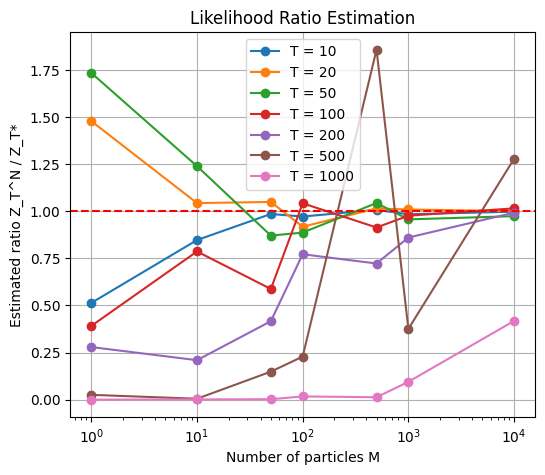

In [8]:
plot_data = {}
for T in T_range:
    plot_data[T] = [ratio_dict_M[M][T] for M in M_range]

# plot_data[10]
plt.figure(figsize=(6, 5))
for T in T_range:
    plt.plot(M_range, plot_data[T], label=f"T = {T}", marker='o')
plt.xscale('log')
plt.xlabel("Number of particles M")
plt.ylabel("Estimated ratio Z_T^N / Z_T*")
plt.title("Likelihood Ratio Estimation")
plt.axhline(y=1, color='r', linestyle='--')
plt.legend()
plt.grid(True)
plt.show()

I picked an M range of [1, 10, 50, 100, 500, 1000, 10000].

We can see that with smaller T, the ratio quickly converges to 1, while it takes larger M to converge fot T = 500 and T = 1000. For T $\leq$ 100, we can see M = 1000 provides a very good estimate already, but for T = 500, we can see very large variance in the ratio around 1, and for T = 1000, M = $10^4$ is still not enough, but we can see the ratio increasing from 0 to 0.5, so we expect a larger M could provide a better estimate. We should choose larger M as T grows.

### 2.4 (b)

We now fix T = 500, and run the estimation for different N

In [9]:
import os
import pickle

M_range = [1, 10, 50, 100, 500, 1000] # ignore 10000 for taking too long
N_range = [100, 500, 1000, 2000, 4000, 6000, 8000, 10000]

if os.path.exists("ratio_dict_N.pkl"):
    # load the ratio data for each N
    with open("ratio_dict_N.pkl", "rb") as f:
        ratio_dict_N = pickle.load(f)

else:
    # run estimation for each N, takes a long time
    ratio_dict_N = {}
    for N in N_range:
        ratio_dict_N[N] = []
        for M in M_range:
            ratio_estimate = estimate_likelihood_ratio(T_range=[500], M=M, N=N)
            # this is a dict with T as key and ratio as value
            ratio_dict_N[N].append(ratio_estimate[500])
            print(f"N = {N}, M = {M} done")
            

    # save the ratio_dict_N to a file
    with open("ratio_dict_N.pkl", "wb") as f:
        pickle.dump(ratio_dict_N, f)
        print("Saved ratio_dict_N to ratio_dict_N.pkl")




N = 100, M = 1 done
N = 100, M = 10 done
N = 100, M = 50 done
N = 100, M = 100 done
N = 100, M = 500 done
N = 100, M = 1000 done
N = 500, M = 1 done
N = 500, M = 10 done
N = 500, M = 50 done
N = 500, M = 100 done
N = 500, M = 500 done
N = 500, M = 1000 done
N = 1000, M = 1 done
N = 1000, M = 10 done
N = 1000, M = 50 done
N = 1000, M = 100 done
N = 1000, M = 500 done
N = 1000, M = 1000 done
N = 2000, M = 1 done
N = 2000, M = 10 done
N = 2000, M = 50 done
N = 2000, M = 100 done
N = 2000, M = 500 done
N = 2000, M = 1000 done
N = 4000, M = 1 done
N = 4000, M = 10 done
N = 4000, M = 50 done
N = 4000, M = 100 done
N = 4000, M = 500 done
N = 4000, M = 1000 done
N = 6000, M = 1 done
N = 6000, M = 10 done
N = 6000, M = 50 done
N = 6000, M = 100 done
N = 6000, M = 500 done
N = 6000, M = 1000 done
N = 8000, M = 1 done
N = 8000, M = 10 done
N = 8000, M = 50 done
N = 8000, M = 100 done
N = 8000, M = 500 done
N = 8000, M = 1000 done
N = 10000, M = 1 done
N = 10000, M = 10 done
N = 10000, M = 50 done

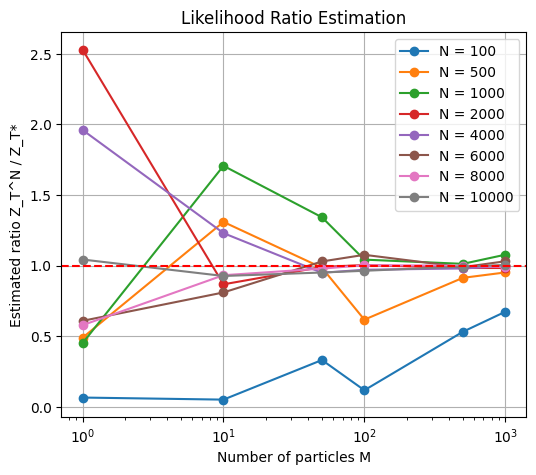

In [10]:
plt.figure(figsize=(6, 5))
for N in N_range:
    plt.plot(M_range, ratio_dict_N[N], label=f"N = {N}", marker='o')
    # ethan = ratio_dict_N[N]
    # values = [list(d.values())[0] for d in ethan]
    # plt.plot(M_range, values, label=f"N = {N}", marker='o')
plt.xscale('log')
plt.xlabel("Number of particles M")
plt.ylabel("Estimated ratio Z_T^N / Z_T*")
plt.axhline(y=1, color='r', linestyle='--')
plt.title("Likelihood Ratio Estimation")
plt.legend()
plt.grid(True)
plt.show()

#### Impact of N on convergence w.r.t. M for fixed T = 500

I picked an M-range of [1, 10, 50, 100, 500, 1000].  
Empirically, smaller N needs larger M to make the ratio converge to 1.

For small N, large M is needed. For especially N = 100, we can see the ratio is < 0.5 with some variance as M increases, until M = 1000 leads to a closer estimate of around 0.6. So even larger M is needed for N = 100, but due to my cmoputation constraint, I couldn't run for larger M

At M = 100, for N $\geq 1000$, this produces satisfactory ratio close to 1 , and at M = 1000, this produces satisfactory ratio close to 1 for N $\geq 500$

At $N = 10000$, even M = 1 produces a fairly good ratio around 1. We suspect that the rate of convergence is at the rate of $O(MN)$ or $O(\sqrt{MN})$



## 2.5 Estimating Params

### (a) NPF

Recall setup:

\begin{align*}
\pi_0(x_0) &= \mathcal{N}(x_0; m_0, P_0) \\
\tau(x_t | x_{t-1}) &= \mathcal{N}(x_t; \theta x_{t-1}, Q) \\
g(y_t | x_t) &= \mathcal{N}(y_t; H x_t, R)
\end{align*}

We re-use our old setup:

\begin{align*}
\theta^* = 0.7,
Q = 1.0,
R = 0.5,
P0 = 1.0,
m0 = 0.0,
H = 1.0,
T = 1000
\end{align*}

and the data generated from 2.2: `q2_data[T] = (x, y)`

Note for the proposal function, I used proposal kernal $\kappa(\cdot|\theta_{t-1}^{(i)}) = \mathcal{N}(0, \sigma^2)$  
where the proposal variance $\sigma$ is tuned to be 0.02, which performs fairly well. Larger $\sigma$ tends to be have too much variance and wonder around, whereas smaller variance leads to slower convergence

#### NPF pseudocode

Let prior $p_0(\theta) = \text{Unif}(-1, 1)$, 
proposal kernal $\kappa(\cdot|\theta_{t-1}^{(i)}) = \mathcal{N}(0, \sigma=0.02)$  

**Sample:**  $ \hat{\theta}_0^{(i)} \sim p_0(\theta) $ 
for $ i = 1, \ldots, M $.

**Init:** $ \bar{x}_t^{(i, j)} \sim \pi_0 = \mathcal{N}(x_0; m_0, P_0)
\quad \text{for} \quad j = 1, \ldots, N,
\quad \text{for} \quad i = 1, \ldots, M. $


**for** $ t = 1, \ldots, T $ **do**

- Propose 
$ \hat{\theta}_t^{(i)} \sim \kappa(\cdot|\theta_{t-1}^{(i)}) \quad \text{for} \quad i = 1, \ldots, M. $

- Sample Inner layer:
$ \bar{x}_t^{(i, j)} \sim \tau_{\hat{\theta}_t^{(i)}}(\cdot|x_{t-1}^{(i, j)}) \quad \text{for} \quad j = 1, \ldots, N,
\quad \text{for} \quad i = 1, \ldots, M. $

- Weight:
$
V_t^{(i, j)} = g(y_t|\bar{x}_t^{(i, j)}),
\quad \text{for} \quad j = 1, \ldots, N,
\quad \text{for} \quad i = 1, \ldots, M $.

- Normalize
$
v_t^{(i,j)} = \frac{V_t^{(i,j)}}{\sum_{j=1}^N V_t^{(i,j)}},
$

- Approximate outler layer:
$
W_t^{(i)} = \frac{1}{N} \sum_{j=1}^N v_t^{(i,j)}
$

- Normalize
$
w_t^{(i)} = \frac{W_t^{(i)}}{\sum_{j=1}^M W_t^{(j)}},
\quad \text{for} \quad i = 1, \ldots, M 
$

- Resample Inner particles
$
\tilde{x}_t^{(i,j)} \sim \sum_{j=1}^N v_t^{(i,j)} \delta_{\bar{x}_t^{(i,j)}}, 
\quad \text{for} \quad j = 1, \ldots, N,
\quad \text{for} \quad i = 1, \ldots, M 
$

- Resample
Sample $ o_t(1), \dots, o_t(N) \sim $ Multinomial( $w_t^{(1)}, \dots, w_t^{(M)}$ ),
and set 

\begin{align*}
\theta_t^{(i)} =& \hat{\theta}_t^{(o_t(i))}\\
x_t^{(i,j)} =& \bar{x}_t^{(o_t(i), j)}
\end{align*}

for $ j = 1, \ldots, N $.

Return $ \{\theta_T^{(i)}\}_{i=1}^M$, and approximate posterior by 

$$
p(\mathrm{d}\theta|y_{1:T}) \approx \frac{1}{M} \sum_{i=1}^M \delta_{\theta_T^{(i)}}(\mathrm{d}\theta)
$$

In [11]:
Q, R, P0, m0, H, T, theta

(1.0, 0.5, 1.0, 0.0, 1.0, 1000, 0.7)

In [12]:
def npf_q2(Y, M=100, N=100, proposal_std=0.001):
    T = len(Y)
    thetas = np.random.uniform(-1, 1, size=M)  # Initial samples from p0(theta)
    theta_particles = np.zeros((T, M))
    theta_estimates = np.zeros(T) # Store estimates of theta over time
    
    # Initialize inner particles for each outer particle
    x_particles = np.random.normal(m0, np.sqrt(P0), size=(M, N))
    
    for t in range(T):
        y = Y[t]
        
        # Step 1: Propose new theta from proposal kernel
        theta_proposed = thetas + np.random.normal(0.0, proposal_std, size=M)

        # Step 2: Propagate inner particles using tau = N(theta * x, Q)
        x_bar = np.zeros((M, N))
        for i in range(M):
            noise = np.random.normal(0, np.sqrt(Q), size=N)
            x_bar[i] = theta_proposed[i] * x_particles[i] + noise  # shape (N,)
        
        # Step 3: Weight update using likelihood g = N(Hx, R)
        log_V = np.zeros((M, N))
        V = np.zeros((M, N)) # to store unnormalized weights
        for i in range(M):
            y_pred = H * x_bar[i]
            log_V[i] = log_p(y, y_pred, R) # shape (N,)
            V[i] = np.exp(log_V[i])

        # Step 4: Normalize inner weights (log domain for stability)
        v = np.zeros((M, N))
        for i in range(M): # normalize each row
            max_log = np.max(log_V[i])
            log_sum = np.log(np.sum(np.exp(log_V[i] - max_log))) + max_log
            log_V[i] -= log_sum  # log-normalize
            v[i] = np.exp(log_V[i])  # normalized weights
        
        # Step 5: Compute outer weights as average inner weights
        W = np.mean(V, axis=1)  # shape (M,)
        W /= np.sum(W)  # normalize outer weights


        # Step 6: Resample inner particles according to v
        x_tilde = np.zeros((M, N))
        for i in range(M):
            indices = np.random.choice(N, size=N, p=v[i])
            x_tilde[i] = x_bar[i][indices]

        # Step 7: Resample outer particles according to W
        o = np.random.choice(M, size=M, p=W)
        thetas = theta_proposed[o]              # Resample thetas (M, )
        x_particles = x_tilde[o]                # Resample inner particles
        theta_particles[t] = thetas             # Store thetas over time
        theta_estimates[t] = np.mean(thetas)    # Store mean theta over time

    return theta_estimates


In [13]:
x, y = q2_data[1000]
theta_estimates = npf_q2(y, M=100, N=1000, proposal_std=0.02)
theta_estimates.shape

(1000,)

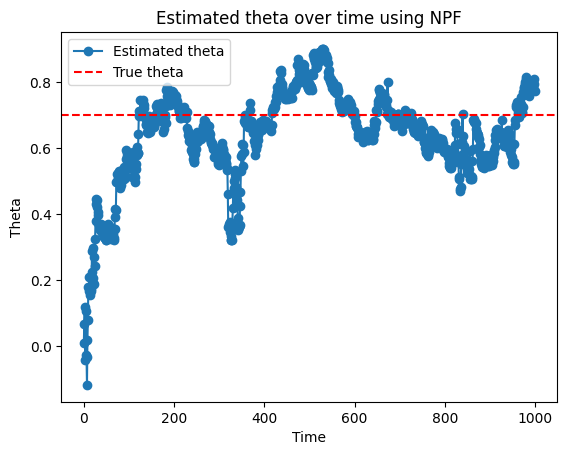

In [14]:
plt.plot(theta_estimates, label='Estimated theta', marker='o')
plt.title('Estimated theta over time using NPF')
plt.xlabel('Time')
plt.ylabel('Theta')
plt.axhline(y=theta, color='r', linestyle='--', label='True theta')
plt.legend()

### 2.5(b)

We note that since the model is linear and gaussian, we were able to compute the exact marginal likelihood $p(y_{1:T})$ in Q2.1 using the Kalman filter, if we know all parameters.

Since we know all params except $\theta$, we can simulate $\theta$ from the prior, compute likelihoods given the simulated $\theta$, and average to form an Imporrance sampler for $p(\theta | y_{1:T})$.

i.e. Kalman filter gives the exact likelihood $p(y_{1:T} \mid \theta)$,
and we have

$$
p(\theta \mid y_{1:T}) \propto p(y_{1:T} \mid \theta) p_0(\theta)
$$

Where $p(y_{1:T} \mid \theta)$ can be computed with Kalman filter for each $\theta_i$

So that if we can get unnormalized weights $W^{(i)} \propto p(y_{1:T} \mid \theta^{(i)})$, self-normalize the weights $w_i = W_i / \sum W_j$, and iteravely update $\sum_i W^{(i)} \hat{\theta}_t^{(i)}$ , we get a SNIS sampler of $p(\theta \mid y_{1:T})$

The pseudocode for the Kalman-based 2 layer approach is given by

**Sample:**  $ \hat{\theta}^{(i)} \sim p_0(\theta) $ 
for $ i = 1, \ldots, M $.

**Inner step**: For each $\theta^{(i)}$, compute the likelihood $p(y_{1:T} \mid \theta^{(i)})$ using Kalman filter. 
Set unnormalized weights $W^{(i)} \propto p(y_{1:T} \mid \theta^{(i)})$

**Normalize**: 
$w^{(i)} = W^{(i)} / \sum_j W^{(j)}$

**resample** 
Sample $ o_t(1), \dots, o_t(N) \sim $ Multinomial( $w^{(1)}, \dots, w^{(M)}$ ),
and set 

\begin{align*}
\theta^{(i)} =& \hat{\theta}^{(o_t(i))}
\end{align*}

for $ j = 1, \ldots, N $.

Return $ \{\theta^{(i)}\}_{i=1}^M$, and approximate posterior by 

$$
p(\mathrm{d}\theta|y_{1:T}) \approx \frac{1}{M} \sum_{i=1}^M \delta_{\theta^{(i)}}(\mathrm{d}\theta)
$$

### 2.5(c)

In [15]:
# we re-state our kalman filter from 2.2, 
# adding the functionality to store weight at each time step
def kalman_filter_infer(y, theta, Q, R, H, m0, P0):
    """Computes log p(y_{1:T})."""
    T = len(y)
    
    # Initialize
    m_hat = m0
    P_hat = P0
    loglik = 0.0
    logliks = np.zeros(T)
    
    for t in range(T):
        # Prediction step
        m_hat = theta * m_hat
        P_hat = theta * P_hat * theta + Q
        
        # Update step
        S_t = H * P_hat * H + R
        K_t = P_hat * H / S_t
        m_t = m_hat + K_t * (y[t] - H * m_hat)
        P_t = (1 - K_t * H) * P_hat
        
        # Increment log-likelihood
        loglik += -0.5 * (np.log(2 * np.pi * S_t) + ((y[t] - H * m_hat) ** 2) / S_t)
        logliks[t] = loglik
        
        # Prepare for next iteration
        m_hat = m_t
        P_hat = P_t

    return logliks

In [16]:
def importance_sampler(Y, M=1000):
    theta_samples = np.random.uniform(-1, 1, size=M)
    theta_estimates = np.zeros(T) # Store estimates of theta over time
    log_weights = np.array([
        kalman_filter_infer(Y, theta, Q, R, H, m0, P0) for theta in theta_samples
    ]) # shape (M, T)
    
    # # Normalize log weights
    log_weights_normalized = np.zeros((M, T))

    for t in range(T): # normalize at each time step
        max_log = np.max(log_weights[:, t])  # for numerical stability
        log_sum = np.log(np.sum(np.exp(log_weights[:, t] - max_log))) + max_log
        log_weights_normalized[:, t] = log_weights[:, t] - log_sum

        weights = np.exp(log_weights_normalized[:, t])
        o = np.random.choice(M, size=M, p=weights)
        thetas = theta_samples[o]         # Resample thetas (M, )
        theta_estimates[t] = np.mean(thetas)

    return theta_estimates

x, y = q2_data[1000]
theta_estimates = importance_sampler(y, M=1000)
theta_estimates.shape


(1000,)

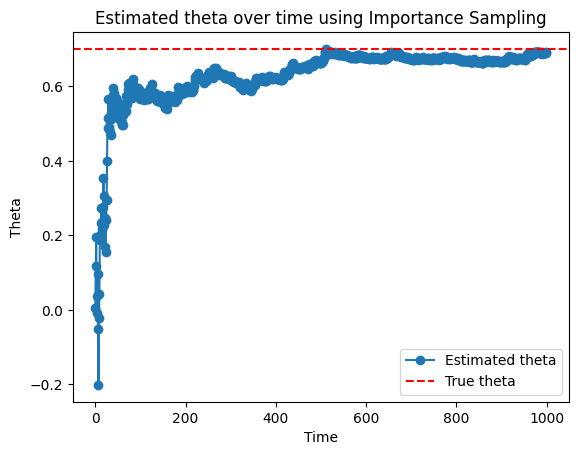

In [17]:
plt.plot(theta_estimates, label='Estimated theta', marker='o')
plt.title('Estimated theta over time using Importance Sampling')
plt.xlabel('Time')
plt.ylabel('Theta')
plt.axhline(y=theta, color='r', linestyle='--', label='True theta')
plt.legend()

### 2.5(d)

At T = 1000, importance sampling using Kalman filter at M = 1000 is faster than NPF using N = 1000, M = 100. IS has complexity of $O(MT)$, while NPF has $O(MNT)$

IS is also faster, converging to the right value of 0.7 by t = 500, and stay there with low variance, given later observations $y_{500:1000}$, demonstrating its robustness.  
Meanwhile NPF still goes up and down throughout, demonstrating much larger variance.

This is as expected, because we are using the information of the model being linear and gaussian, and use the Kalman filter to compute the exact marginal likelihood given each $\theta$, while NPF additionally needs to estimate this likelihood using sampling, leading to larger variance, more computation and slower convergence.